## Settings

In [1]:
# utils
import os
from dotenv import load_dotenv
import copy
import time
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',None) # 또는 숫자 지정
pd.set_option('display.max_columns',None)

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일 저장 경로
    name='NanumBarunGothic' # 별칭
)
fm.fontManager.ttflist.insert(0,fe)
plt.rcParams.update({'font.family' : 'NanumBarunGothic'}) # 한글 패치
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False # 음수 부호 안 깨지게

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Image Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from augraphy import *

### random seed 고정 함수
def set_seed(seed: int = 42):
    """모든 랜덤 시드를 고정합니다.

    :param int seed: 고정할 시드 값, defaults to 42
    """
    random.seed(seed)
    np.random.seed(seed)

    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 멀티 GPU용
        
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass  # torch가 설치되어 있지 않으면 무시
print("현재 jupyter notebook의 실행 경로:", os.getcwd())

project_root = '/data/ephemeral/home/upstageailab-cv-classification-cv_5'
data_dir = os.path.join(project_root, 'data')
print("⚙️ Data Directory Path:", data_dir)

device = 'cpu'
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
print("⚙️ Device :",device)


현재 jupyter notebook의 실행 경로: /data/ephemeral/home/upstageailab-cv-classification-cv_5/codes/practice
⚙️ Data Directory Path: /data/ephemeral/home/upstageailab-cv-classification-cv_5/data
⚙️ Device : cuda


In [2]:
CFG = {
    'model_name': 'resnetrs101.tf_in1k', # timm model name
    'pretrained': True, # timm pretrained 가중치 사용 여부
    'fine_tuning': "full", # fine-tuning 방법론
    # full : pretrained=True, pretrained가중치를 전부 재학습시킨다. 
    # head : pretrained=True, model backbone 부분은 freeze하고 head 부분을 재학습시킨다.
    # custom : pretrained=True, backbone에서도 일부분을 재학습시킨다.
    # scratch : pretrained=False, 모델 구조만 사용하고 모든 가중치를 처음부터 학습시킨다.
    # Loss Function
    'criterion': 'CrossEntropyLoss',
    # optimizer name: SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#217c8d3f60f58044beeac55596433dc6
    'optimizer_name': 'Adam', 
    'lr': 1e-2, # learning rate
    'weight_decay': 1e-4, # weight decay ratio
    # scheduler_name : StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
    # reference : https://www.notion.so/skier-song9/Pytorch-9cfee0520ed6468a94b024ea35e48018?source=copy_link#1d2c8d3f60f58026b71ad399ead029a9
    'scheduler_name': 'ExponentialLR',
    
    # 기타 변수들
    'random_seed': 256, 
    'n_folds': 5, # validation set, cross-validation 시 fold의 개수
    'val_split_ratio': 0.15, # train-val split 비율
    'stratify': True, # validation set 분할 시 stratify 전략 사용 여부
    'image_size': 600, # 만약 multi-scale train/test 시 None으로 설정

    # normalization mean, std
    # full file tuning 시 0.5가 유리
    # pre-trained 모델 사용 시 pre-trained 모델의 mean, std를 사용
    'norm_mean': [0.5, 0.5, 0.5],
    'norm_std': [0.5, 0.5, 0.5],

    # 적용하는 기법들 명시
    'augmentation': {},

    # 모델에 대한 hyperparameters
    'model_layer': {}, # model layer의 filter size, activation function, pooling layer 등 변경 시 작성
    'dropout': None, # model layer에서 dropout 비율 변경 시 작성

    # 학습 시 hyperparameters
    'epochs': 10000, # max epoch
    'patience': 50, # early stopping patience
    'batch_size': 64,

    # device
    'device': device # device name
}
if CFG['patience'] < 5:
    raise ValueError("Ealry stopping patience must be larger than 5!")
# transform dictionary into namespace
from types import SimpleNamespace
CFG = SimpleNamespace(**CFG)

# set random seed
set_seed(CFG.random_seed)

## Data Load

In [3]:
meta = pd.read_csv(os.path.join(data_dir, 'meta.csv'))
meta_dict = zip(meta['target'], meta['class_name'])
meta_dict = dict(meta_dict)
meta_dict[-1] = "None"

In [ ]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    # def __init__(self, csv, path, transform=None):
    def __init__(self, df:pd.DataFrame, path, transform=None, transform_factors=dict()):
        """
        :param pd.DataFrame df: train-val을 위해서는 pandas.Dataframe으로 받아야 함.
        :param str path: 이미지 데이터 디렉토리 경로
        :param _type_ transform: 이미지 변형, defaults to None
        """
        self.df = df
        self.path = path
        self.transform = transform
        self.transform_factors = transform_factors

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            if self.transform_factors.get('metadata'):
                metadatas = []
                bbox_indices_to_update = np.random.choice(range(17), 10)
                image_height, image_width = img.shape[:2]
                num_channels = img.shape[2] if len(img.shape) == 3 else 1
                for index in bbox_indices_to_update:
                    selected_bbox = 
                img = self.transform(image=img, metadata=self.transform_factors['metadata'])['image']
            else:
                img = self.transform(image=img)['image']
        return img, target

In [5]:
# train-validation split
### TO-DO
from sklearn.model_selection import train_test_split
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
train_idx, val_idx = train_test_split(
    range(len(train_df)),
    test_size=CFG.val_split_ratio,
    stratify=train_df['target'],
    shuffle=True,
    random_state=CFG.random_seed
)
print(len(train_idx), len(val_idx))

# Create train and validation CSV files temporarily
train_subset = train_df.iloc[train_idx].reset_index(drop=True)
val_subset = train_df.iloc[val_idx].reset_index(drop=True)

test_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

1334 236


In [6]:
import random
def get_random_index(df, n=3):
    return random.sample(range(len(df)), n)
def visualize_by_index(dataset, indexs):
    global meta_dict
    n = len(indexs)
    plt.figure(figsize=(4*n,3))
    for i in range(n):
        image = dataset[indexs[i]]  # transform은 dataset 내부에서 적용됨
        target = -1
        if isinstance(image, tuple):
            target = image[1]
            image = image[0]  # image, label tuple이면 image만 추출
        image = image.permute(1, 2, 0)  # CHW -> HWC
        # Normalize 역변환 (선택)
        # image = image * torch.tensor(CFG.norm_std) + torch.tensor(CFG.norm_mean)
        # image = image.clip(0, 1)  # 정규화 범위 보정
        image = image.numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Index {indexs[i]} - {meta_dict[target]}")
    plt.tight_layout()
    plt.show()

In [7]:
train_idxs = get_random_index(train_subset, n=3)
val_idxs = get_random_index(val_subset, n=3)
print(train_idx)
print(val_idxs)

[5, 1421, 505, 175, 1093, 1318, 772, 1556, 489, 1170, 519, 1081, 613, 1301, 127, 1059, 562, 595, 260, 38, 847, 99, 400, 1211, 36, 1516, 643, 1158, 1558, 739, 374, 1492, 1522, 19, 1007, 1098, 768, 110, 98, 1265, 628, 124, 415, 848, 305, 1497, 354, 296, 17, 602, 1010, 1039, 202, 293, 567, 27, 763, 360, 468, 667, 1398, 610, 4, 1245, 238, 559, 90, 330, 517, 522, 1434, 1346, 52, 954, 876, 1387, 815, 113, 816, 1278, 936, 394, 1144, 905, 396, 324, 638, 425, 1012, 1086, 1131, 921, 945, 1505, 722, 1263, 413, 732, 1337, 370, 1284, 378, 985, 419, 1141, 1478, 1399, 1538, 708, 1395, 443, 196, 1523, 172, 136, 1447, 252, 1037, 108, 1223, 998, 1240, 1276, 615, 411, 1441, 808, 604, 1569, 1127, 844, 119, 923, 269, 484, 151, 830, 810, 770, 1393, 1115, 1373, 798, 1474, 946, 310, 1286, 764, 333, 380, 1181, 198, 1290, 1414, 1392, 875, 225, 748, 276, 272, 1107, 637, 1452, 1359, 820, 922, 1068, 1443, 1308, 560, 944, 1159, 686, 331, 1483, 438, 1155, 97, 1273, 1407, 953, 191, 787, 1035, 826, 240, 482, 1563, 128

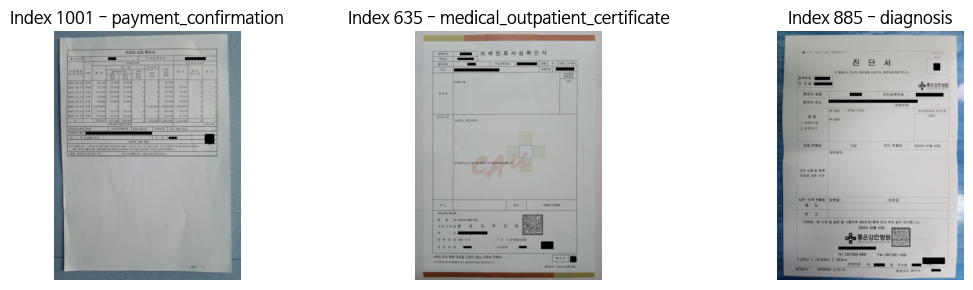

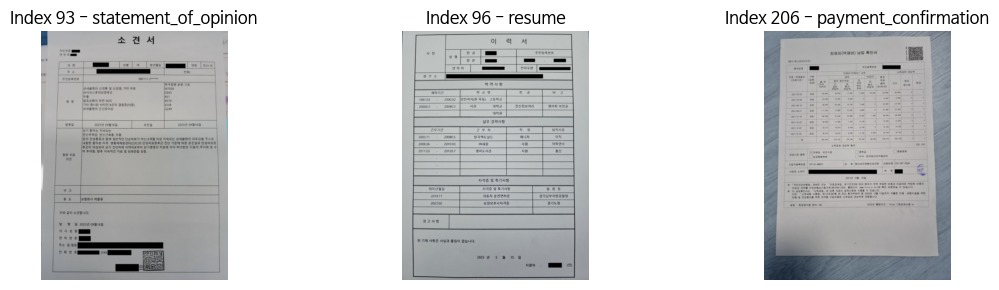

In [29]:
# visualize original image
# augmentation을 위한 transform 코드
train_transform = A.Compose([
    # 이미지 크기 조정
    A.SmallestMaxSize(max_size=CFG.image_size),
    # images normalization
    # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_std),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
val_dataset = ImageDataset(
    df=val_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)
visualize_by_index(val_dataset, indexs=val_idxs)

## Albumentation

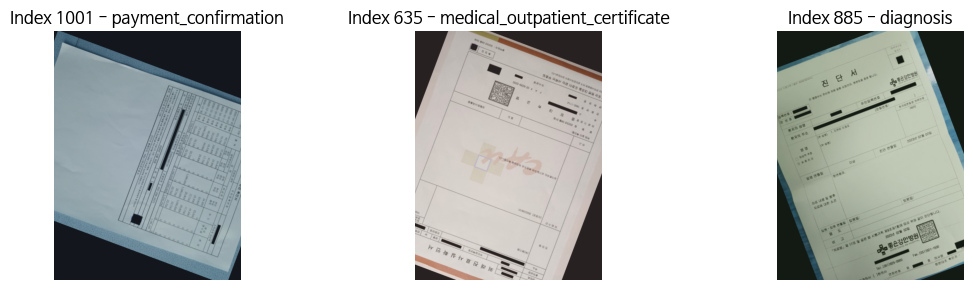

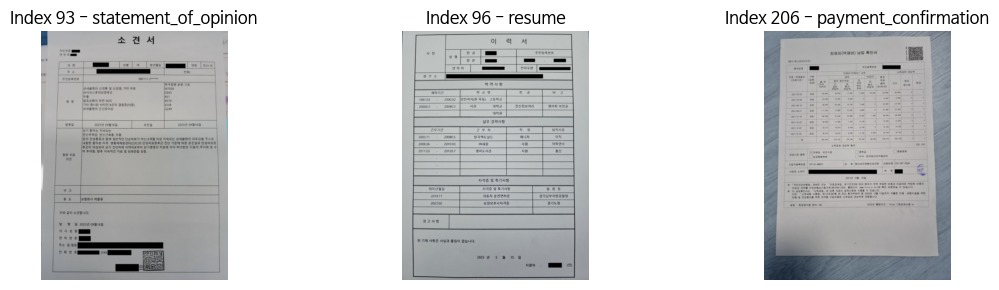

In [37]:
# 기본적인 Shift(이동), Scale(크기변화), Rotate(회전), Brightness(밝기) 증강
# + RGB color jittering

# augmentation을 위한 transform 코드
# https://albumentations.ai/docs/examples/pytorch-classification/#use-albumentations-to-define-transformation-functions-for-the-train-and-validation-datasets
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=1),
        # A.RandomCrop(height=CFG.image_size, width=CFG.image_size),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
        A.RandomBrightnessContrast(p=1),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        # A.CenterCrop(height=CFG.image_size, width=CFG.image_size),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
val_dataset = ImageDataset(
    df=val_subset,
    path=os.path.join(data_dir,'train'),
    transform=val_transform
)
visualize_by_index(val_dataset, indexs=val_idxs)

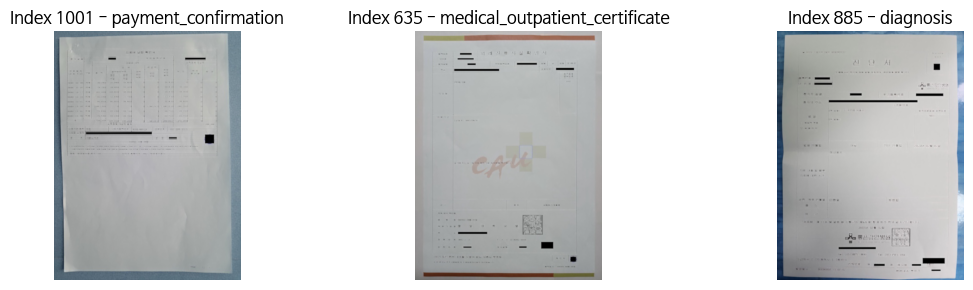

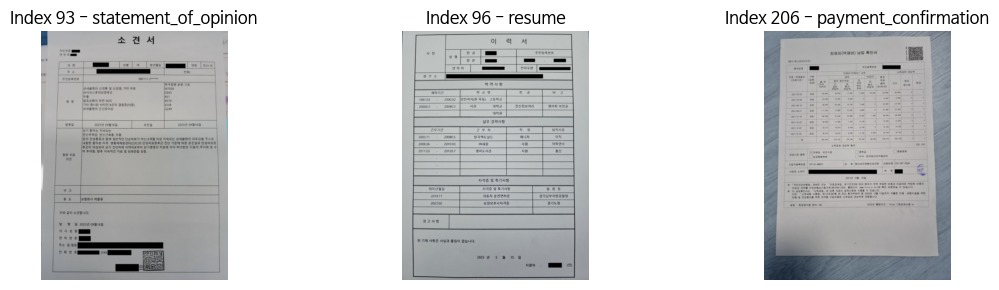

In [21]:
# 고전적 증강 방법인 Dilation과 Erosion
# Dilation : 경계를 흐릿하게
# Erosion : 경계를 강조

# augmentation을 위한 transform 코드
# https://albumentations.ai/docs/examples/example-documents/
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        A.Morphological(p=1, scale=(3, 5), operation="dilation"),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        # A.CenterCrop(height=CFG.image_size, width=CFG.image_size),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
val_dataset = ImageDataset(
    df=val_subset,
    path=os.path.join(data_dir,'train'),
    transform=val_transform
)
visualize_by_index(val_dataset, indexs=val_idxs)

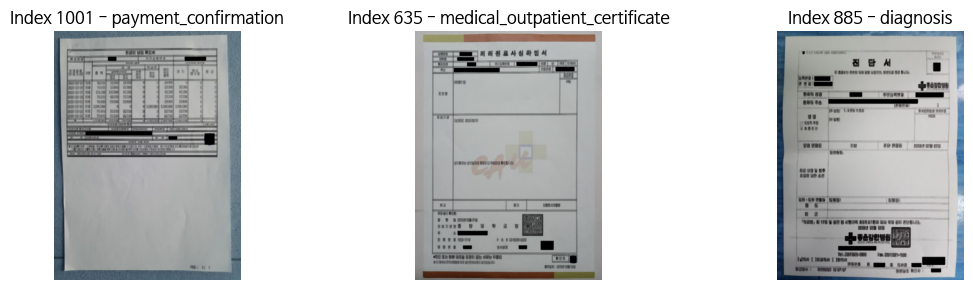

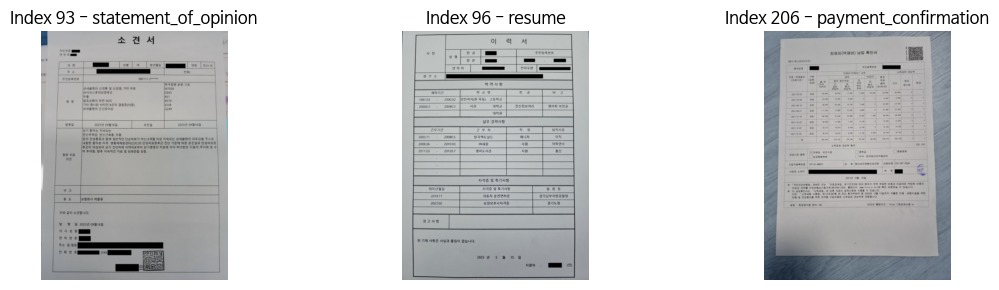

In [31]:
# 고전적 증강 방법인 Dilation과 Erosion
# Dilation : 경계를 흐릿하게
# Erosion : 경계를 강조

# augmentation을 위한 transform 코드
# https://albumentations.ai/docs/examples/example-documents/
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        A.Morphological(p=1, scale=(3,6), operation="erosion"),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=CFG.image_size),
        # A.CenterCrop(height=CFG.image_size, width=CFG.image_size),
        # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
        ToTensorV2(),
    ],
)
val_dataset = ImageDataset(
    df=val_subset,
    path=os.path.join(data_dir,'train'),
    transform=val_transform
)
visualize_by_index(val_dataset, indexs=val_idxs)

In [32]:
# Domain adaptation transforms
# https://albumentations.ai/docs/examples/example-domain-adaptation/

'''
FDA : 비지도 도메인 적응(Unsupervised Domain Adaptation, UDA) 상황에서 간단한 
    **스타일 전이(style transfer)**를 수행하기 위한 기법
    - 이미지의 의미(semantic content)는 그대로 유지하면서도, 스타일적인 요소는 다른 도메인처럼 보이게 바꾸는 것

- 저주파 성분 교환: 복잡한 적대적 학습(adversarial training)을 사용하지 않고, 
    이미지의 저주파 성분(이미지의 전체적인 색감이나 조명 등)을 서로 교환하는 방식으로 도메인을 정렬합니다.

Albumentations의 구현대로라면 target image가 필요하다.
그러나 test dataset의 클래스와 train dataset의 클래스를 mapping해서 증강시키면 data leakage이므로

1. test-dataset에서 모든 저주파 성분을 추출
2. 클러스터링을 통해 test-dataset에서 대표적인 저주파 성분 그룹들을 추출
3. 해당 저주파 성분 그룹을 target으로 하여 FDA 진행

> 나중에 구현
'''
pass

In [ ]:
# Overlay Elements
# https://albumentations.ai/docs/examples/example-overlayelements/

'''
OCR로 텍스트의 bbox를 찾아야 하는 것 같음.
'''
from PIL import Image, ImageDraw, ImageFont
metadata = []

def render_text(bbox_shape, text, font='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', font_color="red", bg_color="white"):
    bbox_height, bbox_width = bbox_shape

    # Create an empty RGB image with the size of the bounding box
    bbox_img = Image.new("RGB", (bbox_width, bbox_height), color=bg_color)
    draw = ImageDraw.Draw(bbox_img)

    # Draw the text in red
    draw.text((0, 0), text, fill=font_color, font=font)

    return np.array(bbox_img)
bbox_indices_to_update = np.random.choice(range(17), 10)
print('bbox_indices_to_update:',bbox_indices_to_update)
image_height, image_width = image.shape[:2]
num_channels = image.shape[2] if len(image.shape) == 3 else 1



# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=CFG.image_size),
#         A.OverlayElements(p=1),
#         A.RandomCrop(p=1, height=CFG.image_size, width=CFG.image_size),
#         A.PlanckianJitter(p=1),
#         A.Affine(p=1, scale=0.9, shear=10, translate_percent=0.05, rotate=10),
#         # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
#         ToTensorV2(),
#     ],
# )
# train_dataset = ImageDataset(
#     df=train_subset,
#     path=os.path.join(data_dir,'train'),
#     transform=train_transform
# )
# visualize_by_index(train_dataset, indexs=train_idxs)

# val_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=CFG.image_size),
#         # A.CenterCrop(height=CFG.image_size, width=CFG.image_size),
#         # A.Normalize(mean=CFG.norm_mean, std=CFG.norm_mean),
#         ToTensorV2(),
#     ],
# )
# val_dataset = ImageDataset(
#     df=val_subset,
#     path=os.path.join(data_dir,'train'),
#     transform=val_transform
# )
# visualize_by_index(val_dataset, indexs=val_idxs)

bbox_indices_to_update: [ 0  7  1 16  6 12  2  7  4  6]


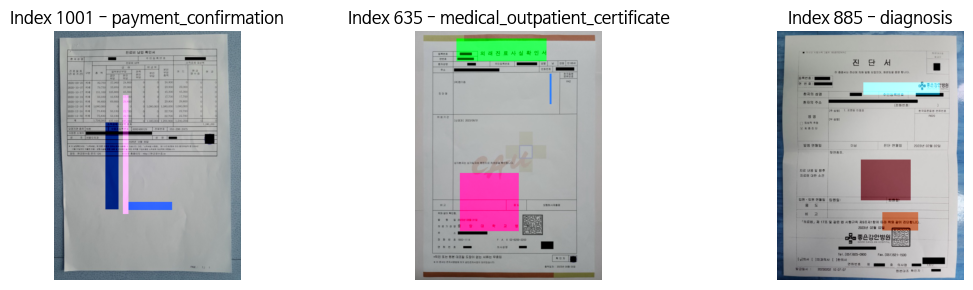

In [45]:
# Overlay Elements를 응용한 K-Replacement
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2

class CustomCutoutWithAug(ImageOnlyTransform):
    def __init__(self, n_holes=3, max_hole_height_ratio=0.5, max_hole_width_ratio=0.5, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
        self.n_holes = n_holes
        self.max_hole_height_ratio = max_hole_height_ratio
        self.max_hole_width_ratio = max_hole_width_ratio
        self.rgb_shift = A.RGBShift(r_shift_limit=200, g_shift_limit=200, b_shift_limit=200, p=1.0)
    def apply(self, image, **params):
        h, w, _ = image.shape

        for _ in range(self.n_holes):
            hole_w = random.randint(1, int(w * self.max_hole_width_ratio))
            hole_h = random.randint(1, int(h * self.max_hole_height_ratio))

            top = random.randint(0, h - hole_h)
            left = random.randint(0, w - hole_w)

            # Crop the region
            patch = image[top:top + hole_h, left:left + hole_w, :].copy()

            # Apply RGBShift to the patch
            augmented_patch = self.rgb_shift(image=patch)["image"]

            # Replace original region with augmented patch
            image[top:top + hole_h, left:left + hole_w, :] = augmented_patch

        return image

# 최종 Compose
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=CFG.image_size),

    # Step 2: Custom Cutout with RGBShift
    CustomCutoutWithAug(n_holes=3, max_hole_width_ratio=0.5, max_hole_height_ratio=0.5, p=1.0),

    # Step 3: ShiftScaleRotate
    # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=360, p=1.0),

    # Step 4: PlanckianJitter, Affine
    # A.PlanckianJitter(p=1.0),
    # A.Affine(p=1.0, scale=0.9, shear=10, translate_percent=0.05, rotate=10)

    ToTensorV2(),
])
train_dataset = ImageDataset(
    df=train_subset,
    path=os.path.join(data_dir,'train'),
    transform=train_transform
)
visualize_by_index(train_dataset, indexs=train_idxs)

## Augraphy